# 🧠 MS Lesion Synthesis Inference Playground 🧠

In [1]:
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler, StableDiffusionInpaintPipeline, UNet2DConditionModel
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
def prepare_mask_and_masked_image(image, mask, black_mask=True, discretize_mask=True):
    image = np.array(image.convert("RGB"))
    # image = image[None].transpose(0, 3, 1, 2)
    image = image.transpose(2, 0, 1)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

    mask = np.array(mask.convert("L"))
    mask = mask.astype(np.float32) / 255.0
    # mask = mask[None, None]
    mask = mask[None]
    if discretize_mask:
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
    else:
        mask[mask < 0.0] = 0
        mask[mask >= 1.0] = 1
    mask = torch.from_numpy(mask)

    if black_mask:
        masked_image = image * (mask < 0.5) + (mask >= 0.5) * -1 if discretize_mask else image * (1 - mask)
    else:
        masked_image = image * (mask < 0.5)

    return mask, masked_image


In [ ]:
# ---- Config ----
model_path = "../lesion-inpating-dreambooth-model-new"        # <- Replace this with your fine-tuned model folder
image_path = "./input_data/flair.png"                     # <- Path to FLAIR MRI image (PNG, JPG)
mask_path = "./input_data/mask.png"                       # <- Binary mask (same size as image)
image_path2 = "./input_data/flair2.png"                   # <- Path to FLAIR MRI image (PNG, JPG)
mask_path2 = "./input_data/mask2.png"                     # <- Binary mask (same size as image)
prompt = "lesion"                                      # <- Prompt used during training
output_path = "./output_data/lesion_output.png"           # <- Where to save the output
num_steps = 25
seed = 17844
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
image_size = 512  # Assumes model was trained at 512x512

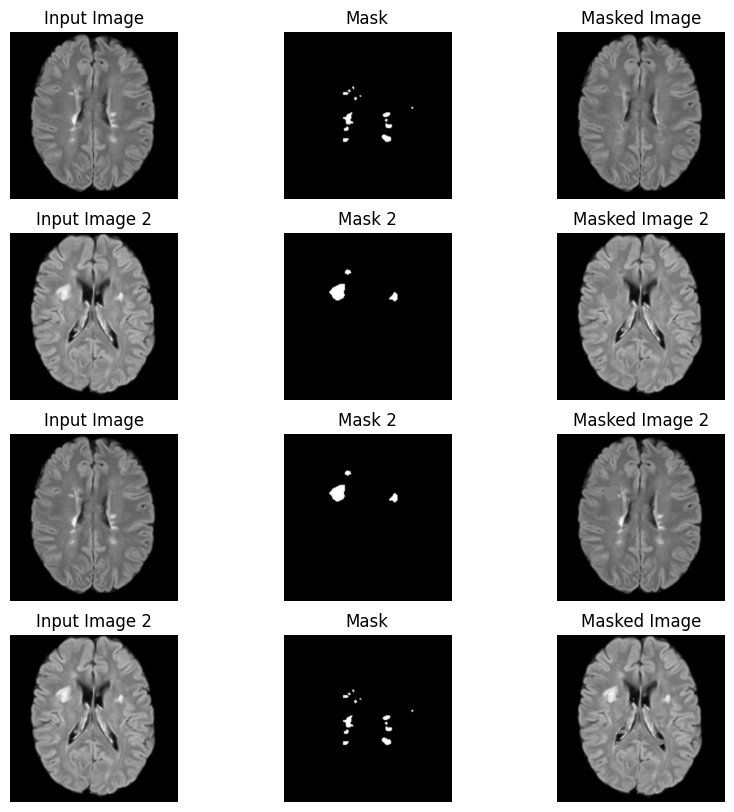

In [112]:
# ---- Load and preprocess ----
def load_image_rgb(path, size=512, mask=False):
    if mask:
        image = Image.open(path).convert("L")
    else:
        image = Image.open(path).convert("RGB")
    return transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size)
    ])(image)

input_image = load_image_rgb(image_path)
mask_image = load_image_rgb(mask_path)
input_image2 = load_image_rgb(image_path2)
mask_image2 = load_image_rgb(mask_path2)

mask, masked_image = prepare_mask_and_masked_image(input_image, mask_image, black_mask=False, discretize_mask=False)

mask2, masked_image2 = prepare_mask_and_masked_image(input_image2, mask_image2, black_mask=False, discretize_mask=False)

mask12, masked_image12 = prepare_mask_and_masked_image(input_image, mask_image2, black_mask=False, discretize_mask=False)

mask21, masked_image21 = prepare_mask_and_masked_image(input_image2, mask_image, black_mask=False, discretize_mask=False)

# unormalize
masked_image = (masked_image + 1.0) / 2.0
masked_image = transforms.ToPILImage()(masked_image.cpu())
masked_image2 = (masked_image2 + 1.0) / 2.0
masked_image2 = transforms.ToPILImage()(masked_image2.cpu())
masked_image12 = (masked_image12 + 1.0) / 2.0
masked_image12 = transforms.ToPILImage()(masked_image12.cpu())
masked_image21 = (masked_image21 + 1.0) / 2.0
masked_image21 = transforms.ToPILImage()(masked_image21.cpu())

# print(f"Loaded image of size {input_image.size}, mask of size {mask_image.size} and masked image of size {masked_image.size()}")

# plot the images
fig, ax = plt.subplots(4, 3, figsize=(10, 10))
ax[0, 0].imshow(input_image)
ax[0, 0].set_title("Input Image")
ax[0, 0].axis("off")
ax[0, 1].imshow(mask_image, cmap="gray")
ax[0, 1].set_title("Mask")
ax[0, 1].axis("off")
ax[0, 2].imshow(masked_image)
ax[0, 2].set_title("Masked Image")
ax[0, 2].axis("off")

ax[1, 0].imshow(input_image2)
ax[1, 0].set_title("Input Image 2")
ax[1, 0].axis("off")
ax[1, 1].imshow(mask_image2, cmap="gray")
ax[1, 1].set_title("Mask 2")
ax[1, 1].axis("off")
ax[1, 2].imshow(masked_image2)
ax[1, 2].set_title("Masked Image 2")
ax[1, 2].axis("off")

ax[2, 0].imshow(input_image)
ax[2, 0].set_title("Input Image")
ax[2, 0].axis("off")
ax[2, 1].imshow(mask_image2, cmap="gray")
ax[2, 1].set_title("Mask 2")
ax[2, 1].axis("off")
ax[2, 2].imshow(masked_image12)
ax[2, 2].set_title("Masked Image 2")
ax[2, 2].axis("off")

ax[3, 0].imshow(input_image2)
ax[3, 0].set_title("Input Image 2")
ax[3, 0].axis("off")
ax[3, 1].imshow(mask_image, cmap="gray")
ax[3, 1].set_title("Mask")
ax[3, 1].axis("off")
ax[3, 2].imshow(masked_image21)
ax[3, 2].set_title("Masked Image")
ax[3, 2].axis("off")
plt.show()


In [103]:
# import inspect

# # ---- Load pipeline ----
# pipe = StableDiffusionInpaintPipeline.from_pretrained(
#     model_path,
#     torch_dtype=torch.float32,
#     safety_checker=None,
# )

# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe = pipe.to(device)
# # pipe.set_progress_bar_config(disable=True)
# # inspect.signature(pipe.__call__)


In [155]:
# take only the biggest lwhite region in the mask_lesion
from skimage.measure import label, regionprops

mask_lesion = np.array(mask_image.convert("L"))
mask_lesion[mask_lesion < 0.5] = 0
mask_lesion[mask_lesion >= 0.5] = 1
label_image = label(mask_lesion)
regions = regionprops(label_image)
max_area = 0
max_region = None
j = 0
for region in regions:
    # if region.area > max_area:
    max_area = region.area
    max_region = region
    j += 1
    if j > 8:
        break
mask_lesion = np.zeros_like(mask_lesion)
mask_lesion[max_region.coords[:, 0], max_region.coords[:, 1]] = 255

# make the lesion bigger
from skimage.morphology import binary_dilation, disk
print(mask_lesion.shape, mask_lesion.dtype, mask_lesion.max())
mask_lesion = binary_dilation(mask_lesion, disk(15))
mask_lesion = mask_lesion.astype(np.uint8) * 255

print(mask_lesion.shape, mask_lesion.dtype, mask_lesion.max())


mask_lesion = torch.from_numpy(mask_lesion).to(device)
mask_lesion = transforms.ToPILImage()(mask_lesion.cpu())
mask_lesion = mask_lesion.convert("RGB")



(512, 512) uint8 255
(512, 512) uint8 255


In [159]:
# ---- Inference ----
generator = torch.Generator(device=device).manual_seed(seed)

result = pipe(
    prompt=prompt,
    image=input_image2,
    mask_image=mask_lesion,
    num_inference_steps=25,
    generator=generator,
    guidance_scale=20.0,
)

output_image = result.images[0]
output_image.save(output_path)

  0%|          | 0/25 [00:00<?, ?it/s]

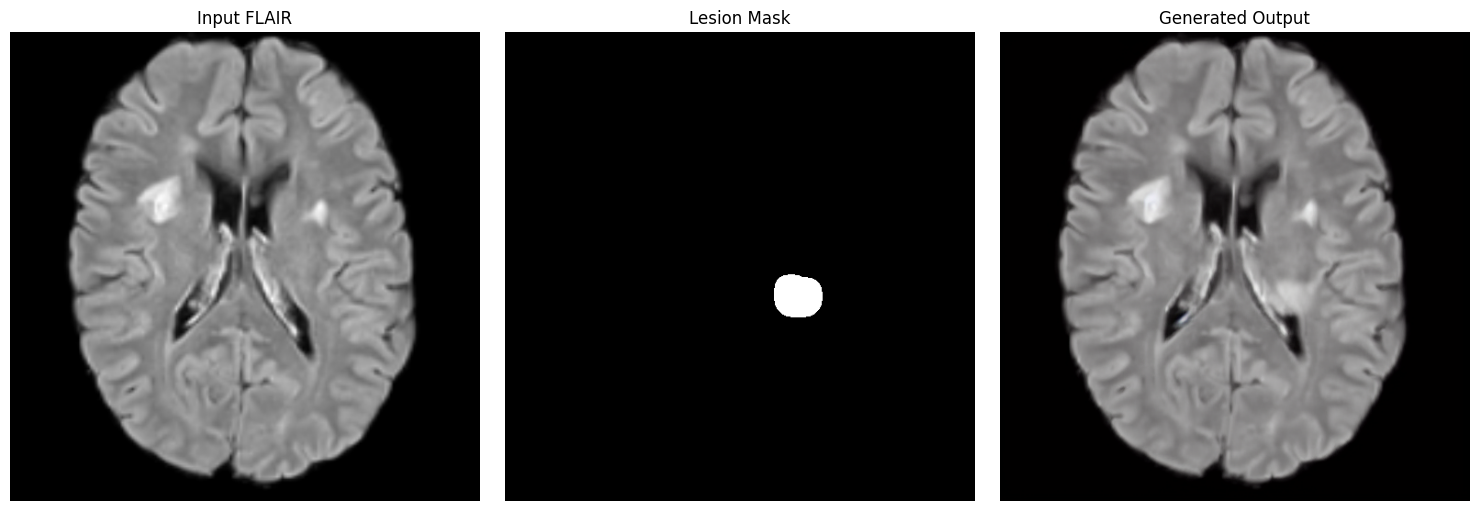

In [160]:
# ---- Visualization ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(input_image2)
axes[0].set_title("Input FLAIR")
axes[1].imshow(mask_lesion)
axes[1].set_title("Lesion Mask")
axes[2].imshow(output_image)
axes[2].set_title("Generated Output")
for ax in axes: ax.axis("off")
plt.tight_layout()
plt.show()

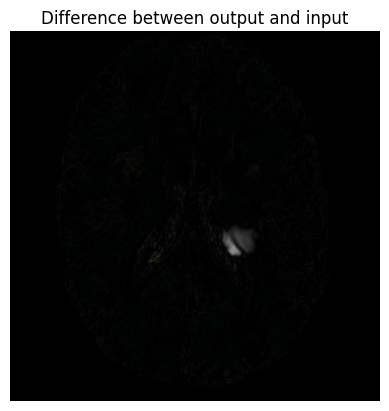

In [161]:
output_image_t = transforms.ToTensor()(output_image)
masked_image_t = transforms.ToTensor()(input_image2)
difference = torch.abs(output_image_t - masked_image_t)
difference = transforms.ToPILImage()(difference.cpu())
plt.imshow(difference)
plt.title("Difference between output and input")
plt.axis("off")
plt.show()

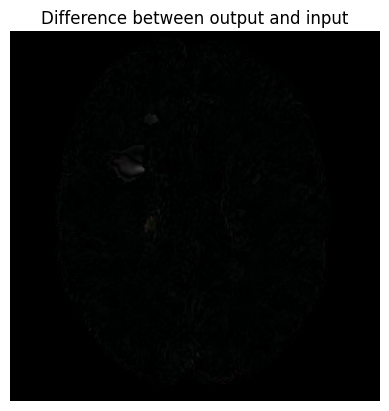

In [ ]:
# calculate the difference between the two images output_image and masked_image2
#to tensor
output_image = transforms.ToTensor()(output_image)
masked_image12 = transforms.ToTensor()(masked_image12)
difference = torch.abs(output_image - masked_image12)
difference = transforms.ToPILImage()(difference.cpu())
plt.imshow(difference)
plt.title("Difference between output and input")
plt.axis("off")
plt.show()


In [92]:
# ---- Inference ----
generator = torch.Generator(device=device).manual_seed(seed)

result = pipe(
    prompt=prompt,
    image=masked_image,
    mask_image=mask_image,
    num_inference_steps=25,
    generator=generator,
    guidance_scale=10.0,
)

output_image2 = result.images[0]


  0%|          | 0/25 [00:00<?, ?it/s]

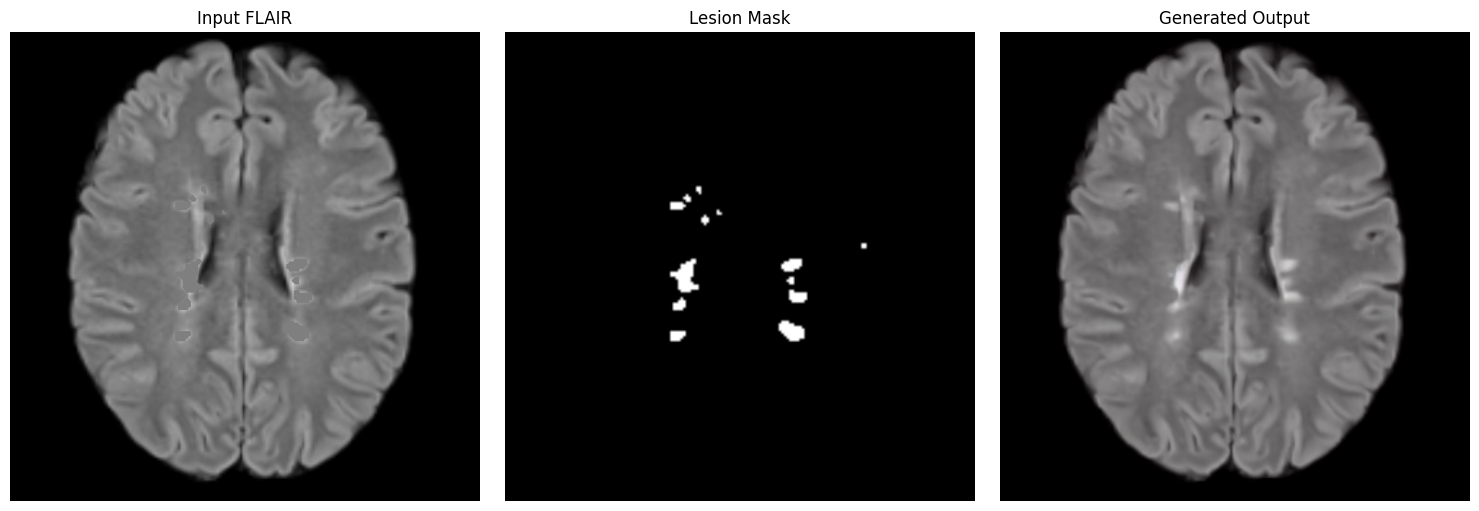

(512, 512) RGB ((0, 204), (0, 204), (0, 204))
(512, 512) RGB ((0, 255), (0, 255), (0, 255))
(512, 512) RGB ((0, 235), (0, 235), (0, 237))


In [93]:
# ---- Visualization ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(masked_image)
axes[0].set_title("Input FLAIR")
axes[1].imshow(mask_image)
axes[1].set_title("Lesion Mask")
axes[2].imshow(output_image2)
axes[2].set_title("Generated Output")
for ax in axes: ax.axis("off")
plt.tight_layout()
plt.show()

print(masked_image.size, masked_image.mode, masked_image.getextrema())
print(mask_image.size, mask_image.mode, mask_image.getextrema())
print(output_image2.size, output_image2.mode, output_image2.getextrema())


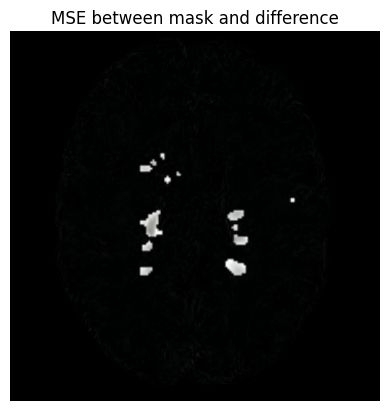

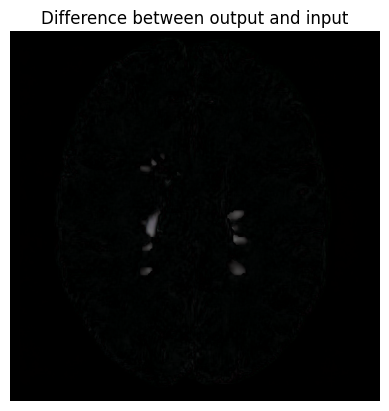

In [21]:
# output_image2 = transforms.ToTensor()(output_image2)
# masked_image = transforms.ToTensor()(masked_image)
mask_image = transforms.ToTensor()(mask_image)
difference = torch.abs(output_image2 - masked_image)
# calculate the mse between the mask and the difference
mse = torch.abs(mask_image - difference)
mse = transforms.ToPILImage()(mse.cpu())
plt.imshow(mse)
plt.title("MSE between mask and difference")
plt.axis("off")
plt.show()
difference = transforms.ToPILImage()(difference.cpu())
plt.imshow(difference)
plt.title("Difference between output and input")
plt.axis("off")
plt.show()